In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib notebook

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cal_neuroim import cal_neuroIm as cn
from ripple_detection.ripple_detection import core as swdCore
from hmmlearn import hmm

In [2]:
def extract_swr_coordinates(inputArray, swr_state_hits=2, state_chain_length=150,
                            swr_length=200, swr_distance=1000):
    """
    inputArray: array of state-indices, e.g. [0,0,1,1,1,2,2,3,2,2,1,1,1 ...]

    swr_state_hits: number of "higher" (i.e. 2 or 3) state indices required in a chain for it to be declared a SWR

    state_chain_length: number of data points considered following a non-0 state occurence as potentially SWR,
                        the potential slice of interest is extended for each 2,3-state within this interval

    swr_length: minimum length requirement for a state chain to be declared  SWR

    swr_distance: refractory period given in data points, in which no SWR is declared

    Algorithm outline:
    Iterate over the array, once state 1 is encountered, check if there is a state-chain
    if yes: is the min_length met and sufficient higher states present?
        if yes: get coordinates, move loop forward by min_distance + event end
        if no: move loop forward by min_length + current pos
    if no: forward loop by max_distance + current pos (there can be no other events in this bucket)
    return coordinate-tuple list
    """
    swr_coordinate_list = []

    i = 0
    inputLenght = len(inputArray) - 1
    while i < inputLenght - swr_length:  # loop over the whole input array
        # state 1 or higher encountered, go to the inner loop for state-chain checking
        if inputArray[i] > 0:
            start_coordinate = i  # start-coordinate for state train
            state_chain_limit = i + state_chain_length  # end-coordinate for state train
            # inner loop that produces the state-chain, if it passes all requirements
            while i < state_chain_limit and i + 1 < inputLenght:  # loop over relevant slice for state train
                # reduce state-int-chain to one int: set all to 1, except for last occurrence
                if inputArray[i] == inputArray[i + 1] or inputArray[i] == 0:
                    inputArray[i] = 1
                # state is not 0,1, extend potential chain region
                if inputArray[i + 1] > 1:
                    state_chain_limit = i + state_chain_length
                i += 1
            # state train is long enough and has min 2 higher states
            if i - start_coordinate > swr_length and np.sum(inputArray[start_coordinate:i] - 1) > swr_state_hits - 2:
                swr_coordinate_list.append([start_coordinate, i])
                i += swr_distance  # forward iterator to respect cool-down time between SWRs
        i += 1

    return swr_coordinate_list

Turn DF into piecewise aggregate of bin-size 5 and do baseline normalization, bandpass filter and RMS

In [3]:
df = pd.read_csv('/home/meop/Python/Projects/SWD/Nov5Ex.txt', sep=",", header=None)

values = []
start = time.time()

for row in df:
    currentValues = df[row]
    listComprehension = [np.mean(currentValues[i:i+2]) for i in range(len(currentValues)-2) if i%3 == 0]
    values.append(listComprehension)

valueArray = np.array(values)
baselineArray, baselineCoordinates = cn.pushToBaseline(valueArray, bucketSize=1000)
filteredArray = swdCore.filter_ripple_band(baselineArray, 20000)

rmsArray = [pd.DataFrame(filteredArray[i]).rolling(20).apply(lambda x: np.mean(x)).values for i in range(5)]
rmsArray = np.nan_to_num(np.array(rmsArray))
print(time.time() - start)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app


115.09168362617493


# State model:
0: noise
1: initial onset, length=50
2: negative overshoot, length=50
3: peak, length=50
Then goes back over 2-1-0
Event length= 300

In [4]:
model = hmm.GaussianHMM(n_components=4, covariance_type='full', init_params='c', params="tc", n_iter=5000)

model.startprob_ = np.array([1.0, 0, 0, 0])

model.transmat_ = np.array([[0.9999, 0.0001, 0, 0],
                            [1/50, 48/50, 1/50, 0],
                            [0, 1/50, 48/50, 1/50],
                            [0, 0, 2/50, 48/50]])

model.means_ = np.array([[0], [1], [-2], [4]])

Idea going forwards: use state transition sequence for sharp wave ripple labeling!
1-2-1-2-1 or 1-2-3-2-1 with interspersed 0s => SWR!



<IPython.core.display.Javascript object>


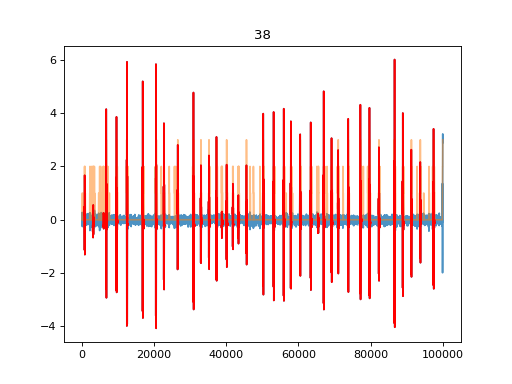

3.7918643951416016


In [14]:
start = time.time()
columnIndex = 2
currentColumn = rmsArray[columnIndex].reshape(-1, 1)

i,j = baselineCoordinates[columnIndex]
baselineDeviance = np.std(rmsArray[columnIndex,i:j])
model.means_ = [[0], [baselineDeviance*8], [baselineDeviance*-14], [baselineDeviance*20]]

model.fit(currentColumn)
test = model.predict(currentColumn)

ripples = extract_swr_coordinates(test, state_chain_length = 100, swr_distance=500, swr_state_hits=3)

#plt.plot(baselineArray[columnIndex], 'g', alpha=0.7)
plt.plot(rmsArray[columnIndex], alpha=0.8)
plt.plot(test, alpha=0.5)
for x in ripples:    
    plt.plot(range(x[0],x[1]), rmsArray[columnIndex,x[0]:x[1]], 'r')
plt.title(len(ripples))

print(time.time() - start)